In [4]:
! pip3 install tqdm
! pip3 install pillow --upgrade
! pip install --upgrade Pillow


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [33]:
import os 
import io
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
#import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont


import boto3

# Create an S3 client
s3_client = boto3.client('s3')

# Now you can use the s3_client to interact with S3 services


In [6]:
urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

# Visualize Data

In [8]:
trimaps_dir = 'data/annotations/trimaps/'

maps = [x for x in os.listdir(trimaps_dir) if x[-3:] == 'png']
print(len(maps))

14780


In [9]:
image_dir = 'data/images/'

images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

7390


In [10]:
images[0]

'yorkshire_terrier_26.jpg'

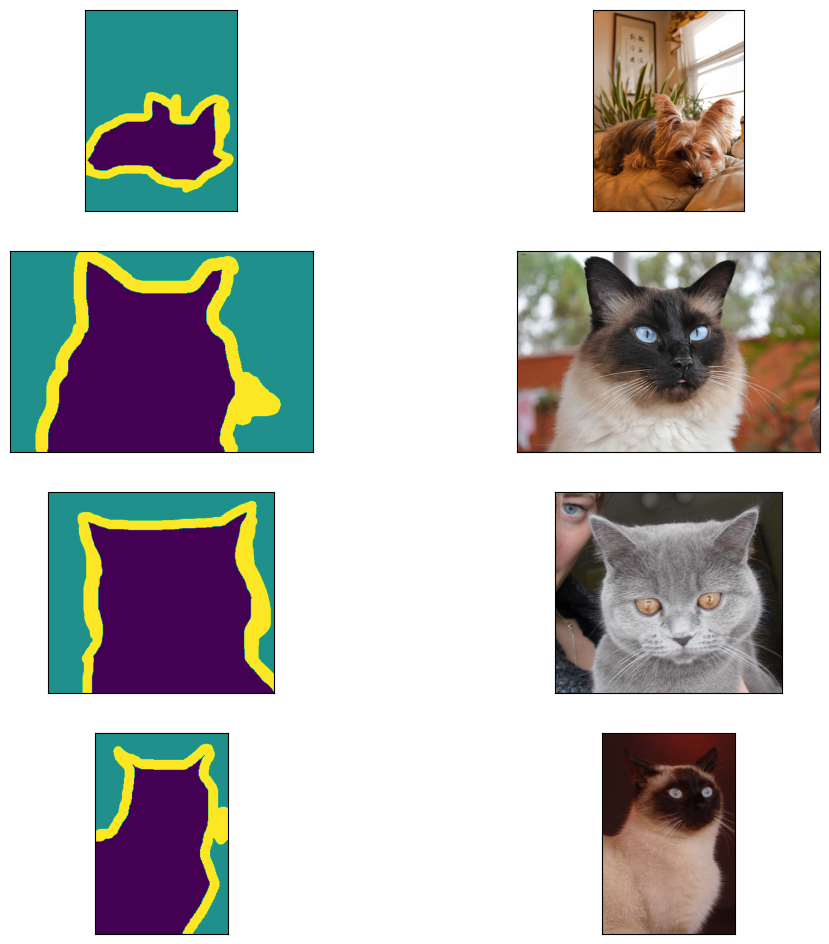

In [11]:
plt.figure(figsize=(12, 12))

for i in range(0, 4):
    index = random.randint(0, len(images) - 1)
    image_name = images[index]
    map_name = images[index].split('.')[0] + '.png'

    plt.subplot(4, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(trimaps_dir, map_name)))
    plt.subplot(4, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(image_dir, image_name)))
plt.show()

In [12]:
img = Image.open(os.path.join(trimaps_dir, maps[0]))
print(np.unique(img))

[1 2 3]


# SageMaker Setup

In [19]:
role= sagemaker.get_execution_role()
bucket_name='petdata'
training_image=get_image_uri(boto3.Session().region_name,'semantic-segmentation',
                             repo_version='latest')
print(training_image)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


825641698319.dkr.ecr.us-east-2.amazonaws.com/semantic-segmentation:1


In [20]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [21]:
def get_map_file(image):
    map_file = image.split('.')[0] + '.png'
    assert map_file in maps
    return map_file
    
for image in tqdm(images):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    
    image_file_path = os.path.join('data/images/', image)
    image_target_path = os.path.join(target_set, image)
    
    map_file_path = os.path.join(trimaps_dir, get_map_file(image))
    map_target_path = os.path.join(target_set + '_annotation', get_map_file(image))
    
    shutil.copy(image_file_path, image_target_path)
    shutil.copy(map_file_path, map_target_path)

100%|██████████| 7390/7390 [00:08<00:00, 851.20it/s] 


In [22]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [23]:
print(len(train_annots), len(train_images))

5576 5576


# Uploading Data to S3

In [24]:
sess=sagemaker.Session()
print('Starting upload')
s3_train_path = sess.upload_data(path='train',bucket=bucket_name,key_prefix='train')
print('Training images uploaded')
s3_train_annotation_path = sess.upload_data(path='train_annotation',bucket=bucket_name,key_prefix='train_annotation')
print('Training Annotations  uploaded')
s3_validation_path = sess.upload_data(path='validation',bucket=bucket_name,key_prefix='validation')
print('validation images uploaded')
s3_validation_annotation_path = sess.upload_data(path='validation_annotation',bucket=bucket_name,key_prefix='validation_annotation')
print('Validation annotations uploaded')

Starting upload
Training images uploaded
Training Annotations  uploaded
validation images uploaded
Validation annotations uploaded


In [25]:
s3_validation_path

's3://petdata/validation'

# SageMaker Estimator

In [28]:
model=sagemaker.estimator.Estimator(
      training_image,
       role=role,
       train_instance_count=1,
       
       train_instance_type='ml.p3.2xlarge',
       train_volume_size=100,
       train_max_run=36000,
       input_mode='File',
       output_path='s3://petdata/output',
       sagemaker_session=sess
       )

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


# Hyperparameters

In [47]:
model.set_hyperparameters(
    backbone='resnet-50',
    algorithm='fcn',
    use_pretrained_model=True,
    crop_size=240,
    num_classes=4,
    epochs=10,
    learning_rate=0.0001,
    optimizer='rmsprop',
    lr_scheduler='poly',
    mini_batch_size=16,
    validation_mini_batch_size=16,
    num_training_samples=len(train_images)
    
)

# Data Channels

In [36]:
# train_data=sagemaker.session.s3_input(s3.train_path,distribution='FullyReplicated',
#                                      content_type='image/jpeg',s3_data_type='S3Prefix')

# validation_data=sagemaker.session.s3_input(s3.validation_path,distribution='FullyReplicated',
#                                      content_type='image/jpeg',s3_data_type='S3Prefix')

# train_annotation_data=sagemaker.session.s3_input(s3.train_annotation_path,distribution='FullyReplicated',
#                                      content_type='image/png',s3_data_type='S3Prefix')

# validation_annotation_data=sagemaker.session.s3_input(s3.validation_annotation_path,distribution='FullyReplicated',
#                                      content_type='image/png',s3_data_type='S3Prefix')



In [42]:
import boto3
from sagemaker import get_execution_role

# Initialize SageMaker session and S3 client
sagemaker_session = boto3.Session().client('sagemaker')
s3_client = boto3.client('s3')

# Define your S3 paths
train_path = 's3://petdata/train'
validation_path = 's3://petdata/validation'
train_annotation_path = 's3://petdata/train_annotation'
validation_annotation_path = 's3://petdata/validation_annotation'

# Create s3_input objects
train_data = sagemaker.session.s3_input(s3_data=train_path, distribution='FullyReplicated',
                                content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_data=validation_path, distribution='FullyReplicated',
                                     content_type='image/jpeg', s3_data_type='S3Prefix')
train_annotation_data = sagemaker.session.s3_input(s3_data=train_annotation_path, distribution='FullyReplicated',
                                           content_type='image/png', s3_data_type='S3Prefix')
validation_annotation_data = sagemaker.session.s3_input(s3_data=validation_annotation_path, distribution='FullyReplicated',
                                                content_type='image/png', s3_data_type='S3Prefix')


The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [44]:
data_channel={
    'train':train_data,
    'validation': validation_data,
    'train_annotation':train_annotation_data,
    'validation_annotation':validation_annotation_data
    
}

In [45]:
data_channel

{'train': <sagemaker.deprecations.deprecated_class.<locals>.DeprecatedClass at 0x7fb4947fe9e0>,
 'validation': <sagemaker.deprecations.deprecated_class.<locals>.DeprecatedClass at 0x7fb4950e8460>,
 'train_annotation': <sagemaker.deprecations.deprecated_class.<locals>.DeprecatedClass at 0x7fb48fd56c50>,
 'validation_annotation': <sagemaker.deprecations.deprecated_class.<locals>.DeprecatedClass at 0x7fb48fd57ca0>}

# Model Training

In [48]:
model.fit(inputs=data_channel,logs=True)

INFO:sagemaker:Creating training-job with name: semantic-segmentation-2023-08-21-06-11-22-741


2023-08-21 06:11:22 Starting - Starting the training job......
2023-08-21 06:11:56 Starting - Preparing the instances for training...
2023-08-21 06:12:50 Downloading - Downloading input data.....................
2023-08-21 06:16:06 Training - Downloading the training image.....................
2023-08-21 06:19:37 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Mon Aug 21 06:20:02 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usag

# Deploy Model

In [49]:
deployed_model=model.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

print('\nModel deployed !')

INFO:sagemaker:Creating model with name: semantic-segmentation-2023-08-21-08-33-54-657
INFO:sagemaker:Creating endpoint-config with name semantic-segmentation-2023-08-21-08-33-54-657
INFO:sagemaker:Creating endpoint with name semantic-segmentation-2023-08-21-08-33-54-657


----------------!
Model deployed !


# Predictions

In [66]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

1814
